In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import zipfile
import os
import glob
import time
import nest_asyncio
import asyncio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
output = '/content/drive/MyDrive/img_align_celeba.zip'
extract_dir = '/content/img_align_celeba'
try:
    start_time = time.time()
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted successfully in {time.time() - start_time:.2f} seconds!")
except Exception as e:
    print(f"Error extracting dataset: {e}")
    print("Ensure 'img_align_celeba.zip' is in /content/drive/MyDrive/.")
    raise

image_size = (64, 64)
image_paths = glob.glob(os.path.join(extract_dir, 'img_align_celeba/*.jpg'))
print(f"Found {len(image_paths)} images in the dataset")

if len(image_paths) == 0:
    raise ValueError("No images found in /content/img_align_celeba/img_align_celeba/. Ensure extraction was successful.")

image_paths = image_paths[:10000]
print(f"Limited to {len(image_paths)} images for faster processing")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted successfully in 35.13 seconds!
Found 202599 images in the dataset
Limited to 10000 images for faster processing


In [ ]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

In [ ]:
def preview_original_images(dataset, num_images=16):
    iterator = iter(dataset)
    preview_images = next(iterator)[:num_images]  # Get first batch, up to 16 images
    preview_images = (preview_images + 1) / 2  # Rescale to [0, 1] for display
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            if i*4 + j < len(preview_images):
                axs[i, j].imshow(preview_images[i*4 + j])
                axs[i, j].axis('off')
    plt.suptitle("Preview of Original CelebA Images")
    plt.show()

In [ ]:
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(128 * 8 * 8, input_dim=100))
    model.add(layers.Reshape((8, 8, 128)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.Activation('tanh'))
    return model

In [ ]:
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
def generate_noise(batch_size, noise_dim=100):
    return np.random.normal(0, 1, (batch_size, noise_dim))

In [ ]:
async def train_dcgan():
    batch_count_total = tf.data.experimental.cardinality(dataset).numpy()
    print(f"Total batches per epoch: {batch_count_total}")
    for epoch in range(epochs):
        batch_count = 0
        start_time = time.time()
        for real_images in dataset:
            # Train discriminator with label smoothing
            real_labels = np.ones((real_images.shape[0], 1)) * 0.9  # Smooth labels
            noise = generate_noise(real_images.shape[0])
            fake_images = generator.predict(noise, verbose=0)
            fake_labels = np.zeros((real_images.shape[0], 1))
            x = np.concatenate([real_images.numpy(), fake_images]) # Convert real_images to NumPy array
            y = np.concatenate([real_labels, fake_labels])
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(x, y)

            # Train generator
            noise = generate_noise(real_images.shape[0])
            g_labels = np.ones((real_images.shape[0], 1))
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, g_labels)

            batch_count += 1
            if batch_count % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_count}/{batch_count_total}, "
                      f"D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]:.4f}, G Loss: {g_loss:.4f}")

        print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

        # Step 7: Monitor training by displaying generated images every 5 epochs
        if (epoch + 1) % 5 == 0:
            noise = generate_noise(16)
            generated_images = generator.predict(noise, verbose=0)
            generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
            fig, axs = plt.subplots(4, 4, figsize=(8, 8))
            for i in range(4):
                for j in range(4):
                    axs[i, j].imshow(generated_images[i*4 + j])
                    axs[i, j].axis('off')
            plt.suptitle(f"Generated Images at Epoch {epoch+1}")
            plt.show()

Dataset pipeline created in 0.09 seconds
Displaying preview of original dataset...


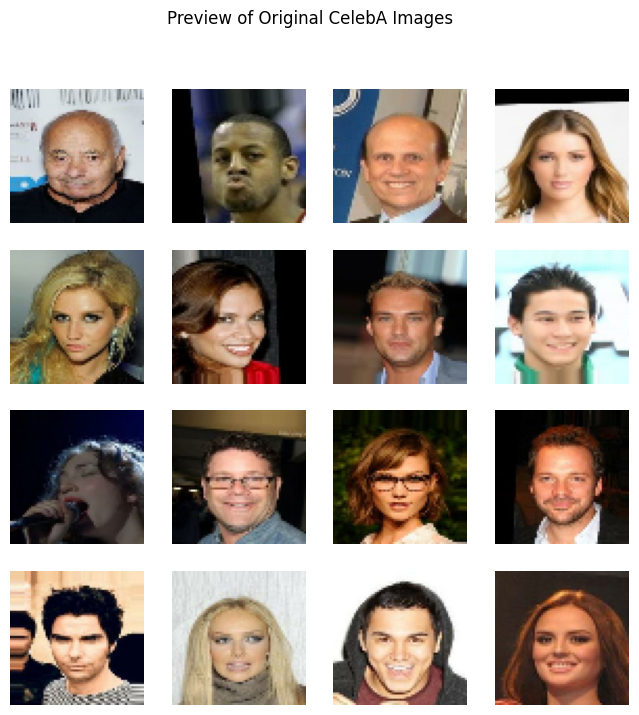

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Total batches per epoch: 157
Epoch 1/20, Batch 100/157, D Loss: 0.2985, D Acc: 0.4557, G Loss: 2.6950
Epoch 1 completed in 48.14 seconds
Epoch 2/20, Batch 100/157, D Loss: 0.2378, D Acc: 0.4827, G Loss: 1.8598
Epoch 2 completed in 27.93 seconds
Epoch 3/20, Batch 100/157, D Loss: 0.2264, D Acc: 0.4880, G Loss: 1.4001
Epoch 3 completed in 27.93 seconds
Epoch 4/20, Batch 100/157, D Loss: 0.2213, D Acc: 0.4904, G Loss: 1.1207
Epoch 4 completed in 26.73 seconds
Epoch 5/20, Batch 100/157, D Loss: 0.2242, D Acc: 0.4911, G Loss: 0.9806
Epoch 5 completed in 26.34 seconds


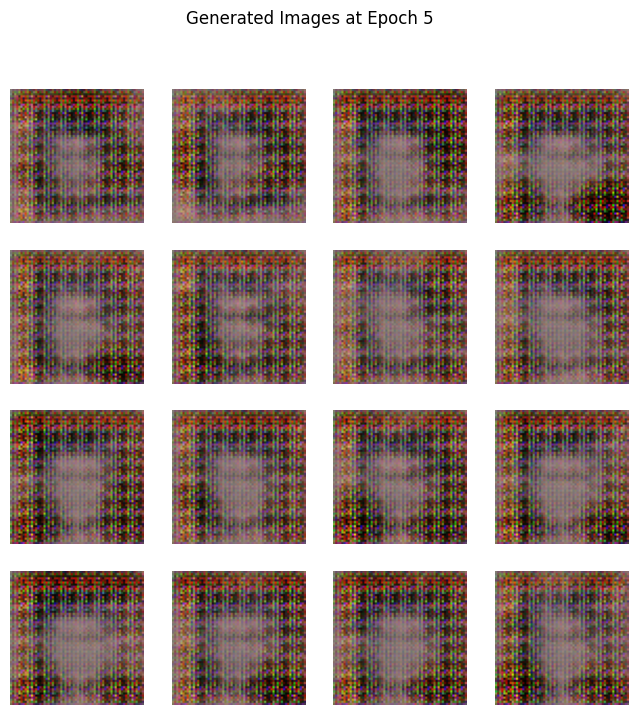

Epoch 6/20, Batch 100/157, D Loss: 0.2194, D Acc: 0.4918, G Loss: 0.8615
Epoch 6 completed in 27.16 seconds
Epoch 7/20, Batch 100/157, D Loss: 0.2193, D Acc: 0.4926, G Loss: 0.7781
Epoch 7 completed in 26.32 seconds
Epoch 8/20, Batch 100/157, D Loss: 0.2262, D Acc: 0.4927, G Loss: 0.7277
Epoch 8 completed in 40.94 seconds
Epoch 9/20, Batch 100/157, D Loss: 0.2266, D Acc: 0.4932, G Loss: 0.6811
Epoch 9 completed in 26.75 seconds
Epoch 10/20, Batch 100/157, D Loss: 0.2291, D Acc: 0.4932, G Loss: 0.6580
Epoch 10 completed in 27.20 seconds


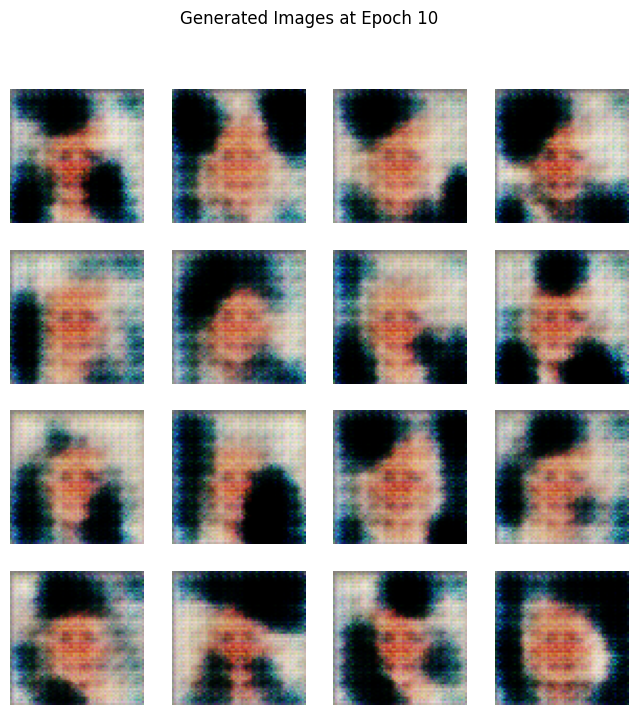

Epoch 11/20, Batch 100/157, D Loss: 0.2282, D Acc: 0.4938, G Loss: 0.6157
Epoch 11 completed in 27.97 seconds
Epoch 12/20, Batch 100/157, D Loss: 0.2265, D Acc: 0.4940, G Loss: 0.5717
Epoch 12 completed in 27.65 seconds
Epoch 13/20, Batch 100/157, D Loss: 0.2281, D Acc: 0.4942, G Loss: 0.5965
Epoch 13 completed in 26.23 seconds
Epoch 14/20, Batch 100/157, D Loss: 0.2240, D Acc: 0.4946, G Loss: 0.5560
Epoch 14 completed in 27.79 seconds
Epoch 15/20, Batch 100/157, D Loss: 0.2245, D Acc: 0.4946, G Loss: 0.5382
Epoch 15 completed in 26.75 seconds


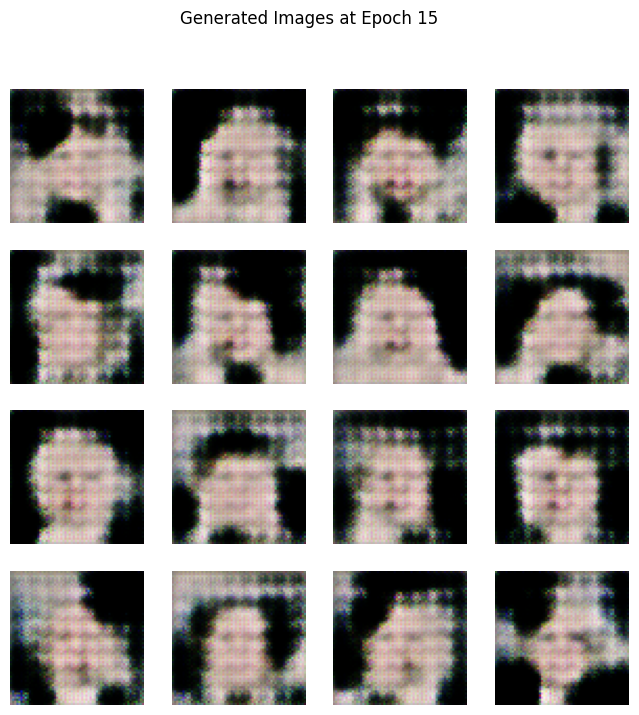

Epoch 16/20, Batch 100/157, D Loss: 0.2243, D Acc: 0.4946, G Loss: 0.5204
Epoch 16 completed in 27.41 seconds
Epoch 17/20, Batch 100/157, D Loss: 0.2233, D Acc: 0.4947, G Loss: 0.5204
Epoch 17 completed in 26.94 seconds
Epoch 18/20, Batch 100/157, D Loss: 0.2231, D Acc: 0.4949, G Loss: 0.4999
Epoch 18 completed in 26.41 seconds
Epoch 19/20, Batch 100/157, D Loss: 0.2235, D Acc: 0.4950, G Loss: 0.4893
Epoch 19 completed in 25.93 seconds
Epoch 20/20, Batch 100/157, D Loss: 0.2252, D Acc: 0.4948, G Loss: 0.5144
Epoch 20 completed in 26.66 seconds


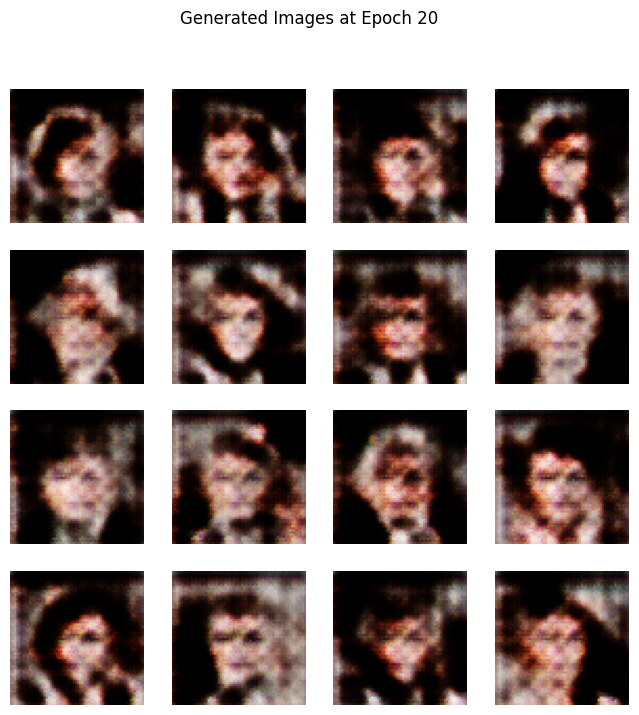

In [ ]:
start_time = time.time()
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=10000).batch(64).prefetch(tf.data.AUTOTUNE)
print(f"Dataset pipeline created in {time.time() - start_time:.2f} seconds")
print("Displaying preview of original dataset...")
preview_original_images(dataset)

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

discriminator.trainable = False
gan = models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

epochs = 20
batch_size = 64


nest_asyncio.apply()  
loop = asyncio.get_event_loop()
loop.run_until_complete(train_dcgan())